<a href="https://colab.research.google.com/github/asanneh/CS109A_2019_GR31_FINAL_PROJECT/blob/master/notebook/FinalProject31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries and Million Playlist Data

In [0]:
#Import the relevant libraries
import pandas as pd
import numpy as np
import scipy.sparse as sparse

Helpful guide to using Google Colab: https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c. 

The Million Playlist Data (MPD) in its raw format is made up of CSVs 0 through 999, each with 1000 playlists. Each CSV is 11 MB, so the unzipped size of the data is 11 GB. For processing in a reasonable time frame, code can be run on the GPU (TPU) by going to Runtime > change runtime type > GPU (TPU). That should give more space. 

To get access to the data, first the Google Drive holding the dataset must be mounted. The raw MPD was merged into a single CSV file called 'combined_playlist.csv'. This CSV file has an extra row denoting what CSV file the playlists came from. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')# force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#load entire playlist to dataframe, note there is a performance hit here since I/O can't be parallelized
#You can limit how many rows you read in by including nrows
songs = pd.read_csv('/content/drive/My Drive/Spotify/combined_playlist.csv') #nrows = 10000000
print(f'dataset shape: {songs.shape}')

dataset shape: (66346428, 10)


In [6]:
print(f'unique CSV files: {len(songs.file_name.unique())}')
print(f'number of playlists: {songs.groupby("file_name").pid.nunique().sum()}')
print(f'unique songs: {len(songs.track_uri.unique())}')
songs.head()

unique CSV files: 1000
number of playlists: 1000000
unique songs: 2262292


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name
0,0,0,Sleeping At Last,spotify:track:2d7LPtieXdIYzf7yHPooWd,spotify:artist:0MeLMJJcouYXCymQSHPn8g,Chasing Cars,spotify:album:0UIIvTTWNB3gRQWFoxoEDh,242564,"Covers, Vol. 2",songs284
1,0,1,Rachael Yamagata,spotify:track:0y4TKcc7p2H6P0GJlt01EI,spotify:artist:7w0qj2HiAPIeUcoPogvOZ6,Elephants,spotify:album:6KzK9fDNmj7GHFbcE4gVJD,253701,Elephants...Teeth Sinking Into Heart,songs284
2,0,2,The Cinematic Orchestra,spotify:track:6q4c1vPRZREh7nw3wG7Ixz,spotify:artist:32ogthv0BdaSMPml02X9YB,That Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,103920,Ma Fleur,songs284
3,0,3,The Cinematic Orchestra,spotify:track:54KFQB6N4pn926IUUYZGzK,spotify:artist:32ogthv0BdaSMPml02X9YB,To Build A Home,spotify:album:5cPHT4yMCfETLRYAoBFcOZ,371320,Ma Fleur,songs284
4,0,4,Leon Bridges,spotify:track:0NeJjNlprGfZpeX2LQuN6c,spotify:artist:3qnGvpP8Yth1AqSBMqON5x,River,spotify:album:4svLfrPPk2npPVuI4kXPYg,238560,Coming Home,songs284


The columns of the MPD are as follows:

1.   **pid:** playlist ID within the original CSV
2.   **pos:** position of song within the playlist
3.   **artist_name:** name of the artist (string)
4.   **track_uri:** unique track Spotify Identifier
5.   **artist_uri:** unique artist Spotify Identifier
6.   **track_name:** name of the track (string)
7.   **album_uri:** unique album Spotify Identifier
8.   **duration_ms:** track duration in ms
9.   **album_name:** name of album
10.  **file_name:** identifier of CSV where playlists came from 

In order to make recommendations for songs for a particular playlist, we will eventually need to create a matrix of playlists by all the unique songs in the MPD. For this, we will need to pick the appropriate song identifier to make sure we are capturing all the unique songs. We will compare **track_name** vs **track_uri** labels to see what is better. 



In [42]:
#what identifier should we use
print(f'unique songs by uri: {len(songs.track_uri.unique())}')
print(f'unique songs by name: {len(songs.track_name.unique())}\n')
#print(f'unique artist+track combos (uri):{len(songs.groupby(["track_uri", "artist_uri"]))}')
#print(f'unique artist+track combos (name):{len(songs.groupby(["track_name", "artist_name"]))}\n')


unique songs by uri: 2262292
unique songs by name: 1483760



We see here that the number of unique songs by **track_uri** is larger than what is given when using **track_name**. This fits well with our understanding that song names can repeated, but that Spotify has unique identifiers for the songs that can disambiguate songs of the same name. Let's take a look at several songs with the same name. 

In [7]:
#drop duplicated songs and count occurences of song names
songs.drop_duplicates(subset = 'track_uri')['track_name'].value_counts()

Intro                                                1559
Silent Night                                          946
Home                                                  843
White Christmas                                       617
O Holy Night                                          554
                                                     ... 
Burro Amarrado                                          1
Appalachian Spring (Original Version): Meno mosso       1
Messa da Requiem: 2. Lacrymosa                          1
The Painters Portrait, Pt. 1                            1
Show Me What You Got (feat. Trina)                      1
Name: track_name, Length: 1483759, dtype: int64

It seems that **track_uris** are a better way to go here - unique to each song and artist, regardless of name overlaps. Especially with cover songs - could be entirely different styles and belong in different playlists. 

Before we proceed with further data analysis, we should make sure that our data is clean - no missingness, consistent types, etc. 

In [8]:
#are there any missing values?
songs.isnull().sum()

pid             0
pos             0
artist_name    13
track_uri       0
artist_uri      0
track_name      2
album_uri       0
duration_ms     0
album_name     15
file_name       0
dtype: int64

In [13]:
#what are the data types?
songs.dtypes

pid             int64
pos             int64
artist_name    object
track_uri      object
artist_uri     object
track_name     object
album_uri      object
duration_ms     int64
album_name     object
file_name      object
dtype: object

In [9]:
#we have some missing values in artist_name, album_name, and track_name
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.artist_name.isnull()]

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name
4293081,591,4,NaN,spotify:track:4eUsRojrbcfPsdUD7qZZo7,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Brindisi Ver. 1,spotify:album:5iVF4oYu6lVTOQj2iu6b2b,194386,Opera Greatest Hits,songs246
5572453,888,72,NaN,spotify:track:6e7I9PmXBHHmNzoHILhY5e,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,The Music of the Night - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,211080,A Musical Affair (Track by Track),songs708
5572454,888,73,NaN,spotify:track:0VffYn4XPllw50b5t8eyU9,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Love Changes Everything - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,186786,A Musical Affair (Track by Track),songs708
8820322,885,128,NaN,spotify:track:14sdk4mdW6KzKfa8tk0hnn,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Hello,spotify:album:2CnxsT3zuHV2rDSVqpKxde,18706,Anticon Label Sampler 1999 - 2004,songs286
8820337,885,143,NaN,spotify:track:0zyLruNSGOBFsYvVKIrhHo,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Pity Party People Interlude,spotify:album:2CnxsT3zuHV2rDSVqpKxde,19413,Anticon Label Sampler 1999 - 2004,songs286
32306209,63,103,NaN,spotify:track:1x4tbfq3ywvTvJVwgVsSHN,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Menace,spotify:album:63T4BKB9CwXzfMuUBE8RWX,232551,Cellar,songs816
32938567,647,8,NaN,spotify:track:0hxxhWW4v5dFTTzudq6BT8,spotify:artist:5acHYRoM4lpJIiHZ4Zi3Is,Flute Gasp,spotify:album:5Us2V8uDxjNnlAqpS5olMr,236191,Xtreme Tremble,songs396
34634330,434,58,NaN,spotify:track:3uxxOSDWiBqKBnbU2eSAxI,spotify:artist:3fmUow9gSgOouUw2UnUtzg,NaN,spotify:album:0yiPGCcuMDakfqcmvY6Rk1,135427,NaN,songs744
39021982,544,20,NaN,spotify:track:5Uhh5hXCYGrONtz3xF5duc,spotify:artist:2uXBg2rcDk1gFkZXi73InJ,Spoken Word: Minister Joseph Pace Ii God Be Wi...,spotify:album:2YPu9Pm0mA3p1VAB3EzUP5,57373,Joe Pace Presents Sunday Morning Service,songs204
55711352,895,80,NaN,spotify:track:0VffYn4XPllw50b5t8eyU9,spotify:artist:4oPYazJJ1o4rWBrTw9lm40,Love Changes Everything - Track by Track,spotify:album:2ozA83nQINAfGWduklekFp,186786,A Musical Affair (Track by Track),songs107


By referencing the **track_uri** in Spotify, it seems that 4 tracks in this category are classical music songs where the primary artist (writer) is listed as N/A. Two tracks are from the same indie rap album, where the primary artist is also N/A. In these cases, it seems that this is truly missing information. What is amusing is that the **artist_uri** for these songs actually points to a reggae group called 'N/A'. When you look at their discography, they have a vast number of classical and opera songs attributed to them...

Besides that, there is one artist called 'NA' and one artist called 'null'. 

It doesn't seem that this will interfere with our collaborative filtering recommender system, just maybe make the song credit information a little more confusing. We will not filter these songs out in the mean time, but we will change the **artist_uri** to NaN to reflect this information for the songs with missing info, and update **artist_name** for those artists named 'NA' and 'null'.   

In [37]:
#we have some missing values in artist_name and album_name. 
#Let's take a look at them, maybe we can fill them in by hand using the uri info

songs.loc[songs.album_name.isnull()]

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,file_name
2518856,957,0,Loop Garou,spotify:track:4LKXkaH6OTl5RMQ4Yfauem,spotify:artist:6ZcNVoWvuMRbhS789e6saA,The Beggar,spotify:album:4zLXjNbJaNvj8X97GAnr5i,165560,NaN,songs332
2518857,957,1,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,songs332
2518858,957,2,Loop Garou,spotify:track:4AgRKRRqDMlHUdApSka5YZ,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Head in the Clouds,spotify:album:4zLXjNbJaNvj8X97GAnr5i,216706,NaN,songs332
4318114,978,63,Loop Garou,spotify:track:4AgRKRRqDMlHUdApSka5YZ,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Head in the Clouds,spotify:album:4zLXjNbJaNvj8X97GAnr5i,216706,NaN,songs246
7069563,513,86,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,songs494
7293324,868,20,Loop Garou,spotify:track:5waP9OdTo3Wx5s4IfAq8OT,spotify:artist:6ZcNVoWvuMRbhS789e6saA,Darlin' Don't Go (feat. Sarah Summers),spotify:album:4zLXjNbJaNvj8X97GAnr5i,261906,NaN,songs133


Loop Garou annoyingly named his album 'N/A' which got translated to a NaN in the pandas dataframe. 

count     1000.00000
mean     66346.42800
std       1677.70028
min      60532.00000
25%      65205.75000
50%      66345.00000
75%      67470.25000
max      72138.00000
Name: track_uri, dtype: float64

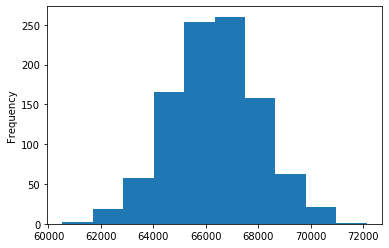

In [0]:
#what is the average length of a playlist
num_songs_in_pl = songs.groupby(by='pid').count()['track_uri']
num_songs_in_pl.plot(kind = 'hist');

num_songs_in_pl.describe()

I am using the two websites here to figure out how to make a recommender from a sparse matrix:
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://jessesw.com/Rec-System/


In [0]:
#make sparse binary matrix of playlist x uniq song? 0 if song not in playlist, 1 if it is
#play_song_mat = np.zeros([len(songs0.pid.unique()), len(songs0.track_uri.unique())])
#play_song_mat.shape

n_pls = songs.pid.unique().shape[0]
n_songs = songs.track_uri.unique().shape[0]

#calculate matrix sparsity
print(f'Num playlists: {n_pls}')
print(f'Num unique songs: {n_songs}')
print(f'Sparsity: {float(songs.shape[0]) /float(n_pls*n_songs) * 100:0.3f}%')

#make sparse matrix
rows = songs.pid.astype('category').cat.codes # make category codes/indices for each playlist
cols = songs.track_uri.astype('category').cat.codes # make category codes/indices for each song
likes = np.ones(rows.shape[0]) #1s if song is in playlist

likes = sparse.csr_matrix((likes, (rows, cols)), dtype=np.float64) #make sparse matrix
print(songs.groupby(by=['pid', 'track_uri']).count()['track_name'].shape)
likes

Num playlists: 1000
Num unique songs: 2262292
Sparsity: 2.933%
